# Dueling Deep Q Network with Prioritized Experience Replay

In this project, we build a Dueling Deep Q Network with Prioritized Experience Replay for the discrete Lunar Lander in OpenAI gym environment. By splitting the q-values of q network into two streams called state-value and action-advantages, Dueling Deep q Network is able to predict more acurratly on q-values. The prioritized experience replay allows the network to select and train experiences which have high td errors, making the training focus on significant experiences. The implemtation also uses fix q-target and soft-update network to further stabilize the training process. (This project is implemented in python and is only for self-practice purpose.)

---
The implementation is based on the following papers:

- [Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602)

- [Human-level control through deep reinforcement learning](https://www.nature.com/articles/nature14236)

- [Deep Reinforcement Learning with Double Q-learning](https://arxiv.org/abs/1509.06461)

- [Prioritized Experience Replay](https://arxiv.org/abs/1511.05952)

- [Dueling Network Architectures for Deep Reinforcement Learning](https://arxiv.org/abs/1511.06581)




### 1. prepare environment

- Switch to tensorflow 2
- Install dependencies
- Import tensorflow, gym, matplotlib...


In [ ]:
# set tensorflow version 2
%tensorflow_version 2.x

In [ ]:
# install dependencies
!pip install -q gym box2d-py pyvirtualdisplay
!apt-get install -qq xvfb python-opengl ffmpeg

     |████████████████████████████████| 450kB 2.7MB/s 
Selecting previously unselected package python-opengl.
(Reading database ... 144328 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Selecting previously unselected package xvfb.
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.4_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.4) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Setting up xvfb (2:1.19.6-1ubuntu4.4) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
# import modules
import tensorflow as tf
import numpy as np
import random
from collections import deque

import gym
from gym import wrappers

import glob
import base64
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
import matplotlib.pyplot as plt

In [ ]:
# create display window for OpenAi gym
display = Display(visible=0, size=(640, 480))
display.start()

### 2. explore OpenAi Gym environment
- [LunarLander-v2](https://gym.openai.com/envs/LunarLander-v2/) from OpenAI Gym

- The goal of this environment is to land the Lunar Lander on the Landing pad with zero speed. This task is considered solved when the average reward is +200 points.

- The 4 discrete actions represent: do nothing, fire left engine, fire main engine, and fire right engine. The 8 states represent: x and y coordinates, x and y velocities, angle, angular velocity and ground contacts of lunar lander legs.

<p align="center">
  <img src="https://github.com/ChienTeLee/dueling_dqn_lunar_lander/raw/master/doc/figure8.png" width="50%" height="50%"> 
</p>

- The reward of firing engine is -0.3 points for each frame. The lander receives -100 points if it crashes, and recieves +100 points if it comes to rest. Landing the lunar lander on pad with zero speed is over +100 points, and ground contact of each lunar lander leg is +10 points. 

- We first play untrained Lunar Lander for 5 times and record the simulation video in "./before_train". The simulation result looks like this:

<p align="center">
  <img src="https://github.com/ChienTeLee/dueling_dqn_lunar_lander/raw/master/doc/before_train.gif" width="50%" height="50%"> 
</p>

- We cans see that the Lunar Lander cannot land well on landing pad, and the average  reward before training is around -100.

In [ ]:
# create OpenAi environment
env = gym.make("LunarLander-v2")
env = wrappers.Monitor(env, "./before_train", force=True, video_callable=lambda episode: (episode+1)>0)
print("state space: " + str(env.observation_space))
print("action space: " + str(env.action_space))

state space: Box(8,)
action space: Discrete(4)


In [ ]:
# play with untrained Lunar Lander and record
total_reward_history = []
for i in range(5):
    state = env.reset()
    total_reward = 0
    while True:
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        total_reward += reward
        if done:
            total_reward_history.append(total_reward)
            break

env.close()

avg_reward = np.mean(total_reward_history)
print("Average reward before training = {}".format(avg_reward))

Average reward before training = -201.30655305623884


In [ ]:
def play_video(path):
    """
    Display videos in the folder at colab notebook terminal.

    Args:
        path (str): Path to the video folder. All videos in the folder will be played.
        
    Returns:
        None
    """
    video_list = glob.glob(path + "/*.mp4")
    html = []
    for file in video_list:
        video = open(file, 'rb').read()
        base64_video = base64.b64encode(video).decode('ascii')
        data_uri = "data:video/mp4;base64," + base64_video
        video_tag = '''
        <video width="640" height="480" autoplay loop>
            <source src={} type="video/mp4">
        </video>'''.format(data_uri)
        html.append(video_tag)
    html_tag = "<br>".join(html)
    ipythondisplay.display(ipythondisplay.HTML(html_tag))

In [ ]:
video_path = "./before_train"
play_video(video_path)

### 2. create dueling deep Q network class

- Here we create dueling deep Q network which splits the q-function into state-value and action-advantages. The state-value indicates the value of the current situation given the current state, and the action-advantages shows how 
good selecting each action is compared to selecting other actions given the current state-value.


- The network architecture is shown in the following diagram:

<p align="center">
  <img src="https://github.com/ChienTeLee/dueling_dqn_lunar_lander/raw/master/doc/figure0.png" width="70%" height="70%"> 
</p>

- The advantage stream is normalized with the mean of the each advantage value, and then it is aggregated with the value stream.

<p align="center">
  <img src="https://github.com/ChienTeLee/dueling_dqn_lunar_lander/raw/master/doc/figure3.png" width="50%" height="50%"> 
</p>



In [ ]:
class Dueling_Deep_Q_network(tf.keras.Model):
    """
    The keras model for Dueling Deep Q network.

    Attributes:
        dense_1 (tf.keras.layers.Dense) : First dense layer with relu activation.
        dense_2 (tf.keras.layers.Dense) : Second dense layer with relu activation.
        value_1 (tf.keras.layers.Dense) : First dense layer of value stream with relu activation.
        value_2 (tf.keras.layers.Dense) : Second dense layer of value stream with linear activation.
        advantage_1 (tf.keras.layers.Dense) : First dense layer of advantage stream with relu activation.
        advantage_2 (tf.keras.layers.Dense) : Second dense layer of advantage stream with linear activation.
    """
    
    def __init__(self, n_state, n_action, hidden_1=128, hidden_2=128, hidden_3=64):
        """
        The __init__ method for Dueling_Deep_Q_network class.

        Args:
            n_state (int): Number of states.
            n_action (int): Number of actions.
            hidden_1 (int): Number of nodes for the first dense hidden layer.
            hidden_2 (int): Number of nodes for the second dese hidden layer.
            hidden_3 (int): Number of nodes for the first layer of value stream and advantage stream.
        """
        super().__init__()
        self.dense_1 = tf.keras.layers.Dense(hidden_1, "relu", kernel_initializer='random_uniform', name="dense_1")
        self.dense_2 = tf.keras.layers.Dense(hidden_2, "relu", kernel_initializer='random_uniform', name="dense_2")

        # value stream
        self.value_1 = tf.keras.layers.Dense(hidden_3, "relu", kernel_initializer='random_uniform', name="value_1")
        self.value_2 = tf.keras.layers.Dense(1, "linear", kernel_initializer='random_uniform', name="value_2")

        # advantage stream
        self.advantage_1 = tf.keras.layers.Dense(hidden_3, "relu", kernel_initializer='random_uniform', name="advantage_1")
        self.advantage_2 = tf.keras.layers.Dense(n_action, "linear", kernel_initializer='random_uniform', name="advantage_2")

        # build and call network
        self.build((None, n_state))
        inputs = tf.keras.Input(shape=n_state)
        self.call(inputs)

    def call(self, inputs):
        """
        The call method for Dueling_Deep_Q_network class.

        Args:
            inputs (tf.Tensor): The state input to the network.
        
        Returns:
            otuput (tf.Tensor): The q-values output of the network.
        """
        dense_1_out = self.dense_1(inputs)
        dense_2_out = self.dense_2(dense_1_out)

        # value stream
        value_1_out = self.value_1(dense_2_out)
        value_2_out = self.value_2(value_1_out)

        # advantage stream
        advantage_1_out = self.advantage_1(dense_2_out)
        advantage_2_out = self.advantage_2(advantage_1_out)
        
        # combine stream
        advantage_mean = tf.reduce_mean(advantage_2_out, axis=1, keepdims=True)
        output = advantage_2_out - advantage_mean + value_2_out
        return output

### 3. create priority replay memory class

- The experinces (state, action, reward, next_state, done) are stored in rotation numpy arrays.

- The priority to the power of alpha is stored in sum tree data sructure.

- Because of the sum tree data sructure, our sampling probability will be proportional to the priority to the power of alpha.

<p align="center">
  <img src="https://github.com/ChienTeLee/dueling_dqn_lunar_lander/raw/master/doc/figure4.png" width="25%" height="25%"> 
</p>

- The importance-sampling weight (IS-weight) are applied to rescale the gradient of each experince. The value is derived using the following equation:

<p align="center">
  <img src="https://github.com/ChienTeLee/dueling_dqn_lunar_lander/raw/master/doc/figure5.png" width="60%" height="60%"> 
</p>

In [ ]:
class PriorityMemory(object):
    """
    The PriorityMemory class. The experiences (state, action, reward, next_state, done) are stored in rotation numpy arrays. The priority
    to the power of alpha is stored in the sum tree data sructure. Because of the sum tree data sructure, our sampling probability will be 
    proportional to the priority to the power of alpha.

    Attributes:
        capacity (int): Maximun capacity of the memory
        node_num (int): Total node number of the sum tree.
        batch_size (int): The batch size for sampling experiences.
        epsilon_error (float): A small error to prevent zero priority.
        alpha (float): Exponent used for sampling priority.
        beta (float): Exponent used for weighed gradients.
        beta_inc (float): Increment for beta exponent.
        n_sample (int): Indicate how many samples has entered the memory for the whole time.
        state_mem (ndarray:float): States stored in numpy array.
        action_mem (ndarray:int): Actions stored in numpy array.
        reward_mem (ndarray:float): Rewards stored in numpy array.
        next_state_mem (ndarray:float): Next states stored in numpy array.
        done_mem (ndarray:float): Terminals stored in numpy array.
        tree_node (ndarray:float): Tree nodes of the sum tree. The stored values are the priorities to the power of alpha.
    """

    def __init__(self, capacity, n_state, batch_size, epsilon_error=0.01, alpha=0.6, beta=0.4, beta_inc=0.001):
        """
        The __init__ method for PriorityMemory class.

        Args:
            capacity (int): Maximun capacity of the memory
            n_state (int): Number of states.
            batch_size (int): The batch size for sampling experiences.
            epsilon_error (float): A small error to prevent zero priority.
            alpha (float): Exponent used for sampling priority.
            beta (float): Exponent used for weighed gradients.
            beta_inc (float): Increment for beta exponent.
        """
        # set parameters
        self.capacity = capacity
        self.node_num = 2 * capacity - 1
        self.batch_size = batch_size
        self.epsilon_error = epsilon_error
        self.alpha = alpha
        self.beta = beta
        self.beta_inc = beta_inc
        self.n_sample = 0

        # create transition memory
        self.state_mem = np.zeros((capacity, n_state), dtype=np.float32)
        self.action_mem = np.zeros((capacity, 1), dtype=np.int32)
        self.reward_mem = np.zeros((capacity, 1), dtype=np.float32)
        self.next_state_mem = np.zeros((capacity, n_state), dtype=np.float32)
        self.done_mem = np.zeros((capacity, 1), dtype=np.float32)

        # create priority memory and tree
        self.tree_node = np.zeros(self.node_num, dtype=np.float32)

    def update_tree(self, tree_index, value):
        """
       Store value in the sum tree at tree_index.

        Args:
            tree_index (int): The tree index for storing value.
            value (float): Value to be stored in sum tree.

        Returns:
            None
        """
        # traverse and add diff to tree nodes
        self.tree_node[tree_index] = value
        while (tree_index != 0):
            if (tree_index % 2 == 0):
                left_child_index = tree_index - 1
                right_child_index = tree_index
            else:
                left_child_index = tree_index
                right_child_index = tree_index + 1
            parent_index = (tree_index - 1) // 2
            self.tree_node[parent_index] = self.tree_node[left_child_index] + self.tree_node[right_child_index]
            tree_index = parent_index

    def get_tree_index(self, value):
        """
        Compare value in leaves of the sum tree and get the corresponding tree index.

        Args:
            value (float): Value to be compared in sum tree.

        Returns:
            tree_index (int): Tree index corresponding to the value.
        """
        # get tree index according to value
        tree_index= 0
        while True:
            left_child_index = 2 * tree_index + 1
            right_child_index = 2 * tree_index + 2

            # break if in final layer
            if left_child_index >= self.node_num:
                break
                
            # traverse node (go to left child or right child)
            if value <= self.tree_node[left_child_index]:
                tree_index = left_child_index
            else:
                tree_index = right_child_index
                value = value - self.tree_node[left_child_index]
        return tree_index

    def get_max_leaf(self):
        """
        Get the maximum value of the tree leaves.

        Args:
            None

        Returns:
            max_value (float): The maximum value of the tree leaves.
        """
        sample_index = min(self.n_sample, self.capacity)
        tree_index = sample_index + self.capacity - 1
        return np.max(self.tree_node[self.capacity-1 : tree_index])

    def get_min_leaf(self):
        """
        Get the minimum value of the tree leaves.

        Args:
            None

        Returns:
            min_value (float): The minimum value of the tree leaves.
        """
        sample_index = min(self.n_sample, self.capacity)
        tree_index = sample_index + self.capacity - 1
        return np.min(self.tree_node[self.capacity-1 : tree_index])

    def store_data(self, state, action, reward, next_state, done):
        """
        Store current experience (state, action, reward, next_state, done) in memory. Set current priority as the maximum value of
        privious priorities, and store the current priority to the power of alpha in the sum tree.

        Args:
            state (ndarray:float): Current state of agent.
            action (int): Executed action.
            reward (float): The reward when taking action in state.
            next_state (ndarray:float): Next state of agent.
            done (float): 1 indicates terminal state, and 0 indicates non-terminal state.

        Returns:
            None
        """
        # store one transition using max priority
        sample_index = self.n_sample % self.capacity

        # store transition
        self.state_mem [sample_index] = state
        self.action_mem [sample_index] = action
        self.reward_mem [sample_index] = reward
        self.next_state_mem [sample_index] = next_state
        self.done_mem [sample_index] = done

        # store max priority
        max_priority_alpha = 1.0 if (self.n_sample==0) else self.get_max_leaf()
        tree_index = sample_index + self.capacity - 1
        self.update_tree(tree_index, max_priority_alpha)

        self.n_sample += 1

    def get_minibatch(self):
        """
        Get minibatch samples and corresponding tree indicies from memory

        Args:

        Returns:
            (tuple): tuple containing:
                 tree_indicies (list:int): List of tree_indicies sampled from memory.
                 states (ndarray:float): Sampled states corresponding to indicies.
                 actions (ndarray:int): Sampled actions corresponding to indicies.
                 rewards (ndarray:float): Sampled rewards corresponding to indicies.
                 next_states (ndarray:float): Sampled next_states corresponding to indicies.
                 dones (ndarray:float): Sampled dones corresponding to indicies.
                 IS_weights (ndarray:float): IS weights for rescaling gradients.
        """
        # uniformly sample from evenly divided segments
        segment = self.tree_node[0] / self.batch_size
        values = [np.random.uniform(i*segment, (i+1)*segment) for i in range(self.batch_size)]  # values to sample
        tree_indicies = [self.get_tree_index(v) for v in values]
        indicies = [tree_index-self.capacity+1 for tree_index in tree_indicies]
        
        # calculate IS weight
        IS_weights = np.power(self.get_min_leaf() / self.tree_node[tree_indicies], self.beta)
        # increase beta
        self.beta = min(1.0, self.beta + self.beta_inc)
        return tree_indicies, self.state_mem[indicies], self.action_mem[indicies], self.reward_mem[indicies], self.next_state_mem[indicies], self.done_mem[indicies], IS_weights

    def update_batch_priority(self, tree_indicies, td_errors):
        """
        Update priorities for sampled minibatch.

        Args:
            tree_indicies (list:int): Tree indicies of sampled minibatch.
            td_errors (ndarray:float): TD errors of the minibatch samples.

        Returns:
            None
        """
        # clip absolute td-error as new priority
        priorities = np.absolute(np.clip(td_errors, -1, 1)) + self.epsilon_error
        priorities_alpha = np.power(priorities, self.alpha)
        for i, index in enumerate(tree_indicies):
            self.update_tree(index, priorities_alpha[i])

### 4. create RL agent class
- Combine the above dueling Q network and prioritized replay memory, we are able to create a Dueling Deep Q Network Agent class. The agent is implemnted with the training algorithm based on the following pseudocode:

<p align="center">
  <img src="https://github.com/ChienTeLee/dueling_dqn_lunar_lander/raw/master/doc/figure2.png" width="80%" height="80%"> 
</p>

- The data flow is shown in the following diagram:

<p align="center">
  <img src="https://github.com/ChienTeLee/dueling_dqn_lunar_lander/raw/master/doc/figure1.png" width="80%" height="80%"> 
</p>


In [ ]:
class Dueling_DQN_Agent(object):
    """
    The class of dueling DQN agent.

    Attributes:
        n_state (int): Number of states.
        n_action (int): Number of actions.
        learning_rate (float): Learning rate for updating network.
        batch_size (int): The batch size for sampling experiences.
        gamma (float): Reward decay.
        tau (float): Interpolation parameter for soft update .
        memory_len (int): Size of memory.
        memory (PriorityMemory): Priority memory using sum tree structure.
        q_evaluate (Dueling_Deep_Q_network): Q evaluate network.
        q_target (Dueling_Deep_Q_network): Q target network.
        optimizer (tf.keras.optimizers.Optimizer): Adam optimizer.
        batch_number (list:int): List of sequence of numbers from 0 to batch_size.
        action_space (list:int): List of sequence of numbers from 0 to n_action.
    """

    def __init__(self, n_state, n_action, learning_rate=0.001, batch_size=32, gamma=0.99, tau=0.01, memory_len=20000):
        """
        The __init__ method for Dueling_DQN_Agent class.

        Args:
            n_state (int): Number of states.
            n_action (int): Number of actions.
            learning_rate (float): Learning rate for updating network.
            batch_size (int): The batch size for sampling experiences.
            gamma (float): Reward decay.
            tau (float): Interpolation parameter for soft update .
            memory_len (int): Size of memory.
        """
        # set parameters
        self.n_state = n_state
        self.n_action = n_action
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau

        # create memory
        self.memory_len = memory_len
        self.memory = PriorityMemory(self.memory_len, self.n_state, self.batch_size)
        
        # create and initialize evaluate and target networks
        self.q_evaluate = Dueling_Deep_Q_network(n_state, n_action)
        self.q_target = Dueling_Deep_Q_network(n_state, n_action)
        self.q_target.set_weights(self.q_evaluate.get_weights())
        self.q_evaluate.trainable = True
        self.q_target.trainable = False

        # create optimizer
        self.optimizer = tf.keras.optimizers.Adam(learning_rate= self.learning_rate)

        # misc
        self.batch_number = np.arange(self.batch_size)[:, None]
        self.action_space = np.arange(self.n_action)

    @tf.function
    def choose_action(self, state, epsilon):
        """
        Choose action accroding to epsion. If random float >= epsilon, choose greedy move. Otherwise, choose random move.

        Args:
            state (ndarray:float): Current state of agent.
            epsilon (float): Parameter for selecting action.

        Returns:
            action (int): The selected action.
        """
        # random or greedy choose action according to epsilon
        if tf.random.uniform(shape=[]) >= epsilon:
            q_evaluate = self.q_evaluate(state[None,:])
            action = tf.argmax(q_evaluate, axis=1)[0]
        else:
            action = tf.random.shuffle(self.action_space)[0]
        return action
    
    def store_transition(self, state, action, reward, next_state, done):
        """
        Store one experience (state, action, reward, next_state, done) in memory.

        Args:
            state (ndarray:float): Current state of agent.
            action (int): Executed action.
            reward (float): The reward when taking action in state.
            next_state (ndarray:float): Next state of agent.
            done (float): 1 indicates terminal state, and 0 indicates non-terminal state.

        Returns:
            None
        """
        # store one transition in memory
        self.memory.store_data(state, action, reward, next_state, done)

    def experience_replay(self):
        """
        Random sample minibatch experiences and train Q evaluate network. After that, update priorities for sampled experiences.

        Args:
            None
        Returns:
            None
        """
        # batch update network and update priority
        if self.memory.n_sample < self.batch_size:
            return

        tree_indicies, states, actions, rewards, next_states, dones, IS_weights = self.memory.get_minibatch()
        td_errors = self.train_step(states, actions, rewards, next_states, dones, IS_weights)
        self.memory.update_batch_priority(tree_indicies, td_errors)
    
    @tf.function
    def train_step(self, states, actions, rewards, next_states, dones, IS_weights):
        """
        Train step for training Q evaluate netowrk. The update gradients are rescaled using IS weights.

        Args:
            states (ndarray:float): Sampled minibatch states.
            actions (ndarray:int): Sampled minibatch actions.
            rewards (ndarray:float): Sampled minibatch rewards.
            next_states (ndarray:float): Sampled minibatch next_states.
            dones (ndarray:float): Sampled minibatch dones.
            IS_weights (ndarray:float): IS weights for rescaling gradients.

        Returns:
            td_errors (tf.Tensor): TD errors of the minibatch samples.
        """
        # apply gradients to network
        new_actions = tf.argmax(self.q_evaluate(next_states), axis=1)[:, None]
        new_actions_zip = tf.concat([self.batch_number, new_actions], axis=1)
        next_q_targets = self.q_target(next_states)
        y_true = rewards + (1-dones) * self.gamma * tf.gather_nd(next_q_targets, new_actions_zip)[:, None]
        actions_zip = tf.concat([self.batch_number, actions], axis=1)

        with tf.GradientTape() as tape:
            y_pred_all = self.q_evaluate(states)
            y_pred = tf.gather_nd(y_pred_all, actions_zip)[:, None]
            td_errors = y_true - y_pred
            total_loss = self.weighted_huber_loss(td_errors, IS_weights)

        gradients = tape.gradient(total_loss, self.q_evaluate.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.q_evaluate.trainable_variables))
        return td_errors
    
    @tf.function
    def weighted_huber_loss(self, td_errors, IS_weights, delta=1.0):
        """
        Calculate sum of Huber Loss which is rescaled using IS weights.

        Args:
            td_errors (tf.Tensor): TD errors of the minibatch samples.
            IS_weights (ndarray:float): IS weights for rescaling gradients.
            delta (float): Hyperparameter of Huber Loss.

        Returns:
            total_loss (tf.Tensor): Sum of weighted Huber Loss rescaled using IS weights.
        """
        huber_loss = tf.where(tf.abs(td_errors) <= delta, 0.5 * tf.square(td_errors), delta * (tf.abs(td_errors) - 0.5 * delta))
        weighted_huber_loss = IS_weights * huber_loss
        return tf.reduce_sum(weighted_huber_loss)


    def soft_update_network(self):
        """
        Soft update weight of Q target network. q_target =  tau * q_evaluate + (1 - tau) * q_target.

        Args:
            None

        Returns:
            None
        """
        # soft update target network weight with tau * q_evaluate + (1 - tau) * q_target
        q_evaluate_weight = self.q_evaluate.get_weights()
        q_target_weight = self.q_target.get_weights()
        for i in range(len(q_target_weight)):
            q_target_weight[i] = self.tau * q_evaluate_weight[i] + (1 - self.tau) * q_target_weight[i]
        self.q_target.set_weights(q_target_weight)

#### 5. train RL agent
- Create OpenAI Gym environment

- Create Dueling DQN agent

- View the training process and see plots of training curve.

In [ ]:
# create environment and agent
env = gym.make("LunarLander-v2")
env = wrappers.Monitor(env, "./during_train", force=True, video_callable=lambda episode: (episode+1)%50==0)

n_state = env.observation_space.shape[0]
n_action = env.action_space.n
dueling_dqn_agent = Dueling_DQN_Agent(n_state, n_action)

# view network summary
dueling_dqn_agent.q_evaluate.summary()

Model: "dueling__deep_q_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1152      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
value_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
value_2 (Dense)              (None, 1)                 65        
_________________________________________________________________
advantage_1 (Dense)          (None, 64)                8256      
_________________________________________________________________
advantage_2 (Dense)          (None, 4)                 260       
Total params: 34,501
Trainable params: 34,501
Non-trainable params: 0
_______________________________________

In [ ]:
# inititalize parameters 
N_EPISODE = 1000
epsilon = 0.5
epsilon_min = 0.01
epsilon_decay = (epsilon_min/epsilon) ** (1.0/(N_EPISODE*0.1))
replay_interval = 5

done = False
solved = False
reward_window = deque(maxlen=100)
total_reward_history = []
avg_reward_history = []

# start training loop
for episode in range(N_EPISODE):
    state = env.reset()
    total_reward = 0
    done = 0
    time = 0

    while not done:
        time += 1
        # take action in environment
        action = dueling_dqn_agent.choose_action(state, epsilon)
        next_state, reward, done, info = env.step(action.numpy())
        total_reward += reward
        
        # store transition
        dueling_dqn_agent.store_transition(state, action, reward, next_state, done)
        
        # experience replay
        if (time % replay_interval == 0):
            dueling_dqn_agent.experience_replay()
            dueling_dqn_agent.soft_update_network()

        state = next_state

    # update epsilon
    epsilon = max(epsilon *epsilon_decay, epsilon_min)

    # record training history
    total_reward_history.append(total_reward)
    reward_window.append(total_reward)
    avg_reward = np.mean(reward_window)
    avg_reward_history.append(avg_reward)
    print("episode={:d}/{:d}, epsilon={:.4f}, total_reward={:.4f}, avg_reward={:.4f}".format(episode, N_EPISODE, epsilon, total_reward, avg_reward))
    
    if episode >= 100 and avg_reward >= 200:
        solved = True
        print("Solved at {} episode!".format(episode))
        break

if not solved:
    print ("Not solve the problem yet!")
print("Average reward = {}".format(avg_reward))
print ("End Training \n")

env.close()

episode=0/1000, epsilon=0.4808, total_reward=-424.6963, avg_reward=-424.6963
episode=1/1000, epsilon=0.4624, total_reward=-157.1716, avg_reward=-290.9339
episode=2/1000, epsilon=0.4446, total_reward=-185.4379, avg_reward=-255.7686
episode=3/1000, epsilon=0.4276, total_reward=-117.9581, avg_reward=-221.3159
episode=4/1000, epsilon=0.4112, total_reward=-246.9525, avg_reward=-226.4433
episode=5/1000, epsilon=0.3954, total_reward=-184.6023, avg_reward=-219.4698
episode=6/1000, epsilon=0.3802, total_reward=-151.7395, avg_reward=-209.7940
episode=7/1000, epsilon=0.3656, total_reward=-106.2260, avg_reward=-196.8480
episode=8/1000, epsilon=0.3516, total_reward=-91.3422, avg_reward=-185.1251
episode=9/1000, epsilon=0.3381, total_reward=-462.9735, avg_reward=-212.9100
episode=10/1000, epsilon=0.3251, total_reward=-216.8202, avg_reward=-213.2655
episode=11/1000, epsilon=0.3127, total_reward=-111.7610, avg_reward=-204.8068
episode=12/1000, epsilon=0.3007, total_reward=-123.5426, avg_reward=-198.55

In [ ]:
def plot_figure(data, x_label, y_label, title, path):
    """
        Plot figure for data.

        Args:
            data (list:float): List of input data.
            x_label (str): Name for x label.
            y_label (str): Name for y label.
            title (str): Name for title.
            path (str): Path to store plot.

        Returns:
            None
        """
    plt.figure()
    x = np.arange(0, len(data))
    y = data
    plt.plot(x, y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.savefig(path)
    plt.show(block=False)

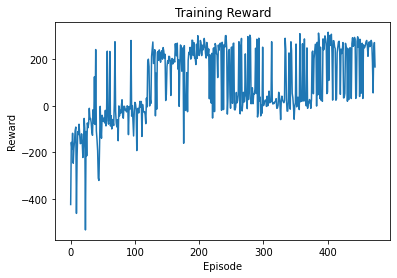

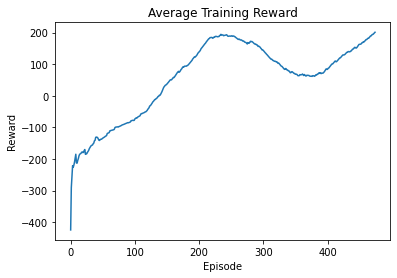

In [ ]:
# plot the training curve
plot_figure(total_reward_history, "Episode", "Reward", "Training Reward", "./train_reward.png")
plot_figure(avg_reward_history, "Episode", "Reward", "Average Training Reward", "./avg_train_reward.png")

### play with trained prioritized dqn agent

- After training, the simulation videos are saved in folder "./after_train", and the result looks like the following:

<p align="center">
  <img src="https://github.com/ChienTeLee/dueling_dqn_lunar_lander/raw/master/doc/after_train.gif" width="50%" height="50%"> 
</p>

- we can see that the Lunar Lander can safely land on the landing spot, and the average reward is around +200 points.

In [ ]:
env = gym.make("LunarLander-v2")
env = wrappers.Monitor(env, "./after_train", force=True, video_callable=lambda episode: (episode+1)>0)
total_reward_history = []

# play 5 trials with greedy move
epsilon = 0.0
for episode in range(5):
    state = env.reset()
    total_reward = 0
    done = 0

    while not done:
        action = dueling_dqn_agent.choose_action(state, epsilon)
        next_state, reward, done, info = env.step(action.numpy())
        total_reward += reward
        state = next_state

    total_reward_history.append(total_reward)

avg_reward = np.mean(total_reward_history)
print("Average reward after training = {}".format(avg_reward))
print ("End Playing")
env.close()

Average reward after training = 273.6020961011317
End Playing


In [ ]:
video_path = "./after_train"
play_video(video_path)

In [ ]:
#save result to zip file
!zip -r output.zip ./before_train ./during_train ./after_train avg_train_reward.png train_reward.png

  adding: before_train/ (stored 0%)
  adding: before_train/openaigym.video.0.125.video000003.mp4 (deflated 6%)
  adding: before_train/openaigym.video.0.125.video000000.meta.json (deflated 60%)
  adding: before_train/openaigym.episode_batch.0.125.stats.json (deflated 43%)
  adding: before_train/openaigym.video.0.125.video000002.meta.json (deflated 60%)
  adding: before_train/openaigym.video.0.125.video000002.mp4 (deflated 6%)
  adding: before_train/openaigym.video.0.125.video000004.meta.json (deflated 60%)
  adding: before_train/openaigym.manifest.0.125.manifest.json (deflated 71%)
  adding: before_train/openaigym.video.0.125.video000003.meta.json (deflated 60%)
  adding: before_train/openaigym.video.0.125.video000001.mp4 (deflated 6%)
  adding: before_train/openaigym.video.0.125.video000004.mp4 (deflated 6%)
  adding: before_train/openaigym.video.0.125.video000001.meta.json (deflated 60%)
  adding: before_train/openaigym.video.0.125.video000000.mp4 (deflated 6%)
  adding: during_train/